<a href="https://colab.research.google.com/github/Kakkarot217/SRGAN_train/blob/master/SRGAN_train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install torchsummary

In [0]:
import os
import torch
import torch.nn as n
import torch.nn.functional as f
import numpy as np
import os
from torchsummary import summary
import torch.optim as optim
from tqdm import tqdm
from torchvision import models
import cv2
from matplotlib import pyplot as plt

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
!git clone https://github.com/vishal1905/Super-Resolution.git

Cloning into 'Super-Resolution'...
remote: Enumerating objects: 3, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 216 (delta 0), reused 0 (delta 0), pack-reused 213
Receiving objects: 100% (216/216), 1.35 MiB | 11.03 MiB/s, done.
Resolving deltas: 100% (1/1), done.


In [0]:
%cd celeba-dataset/img_align_celeba/img_align_celeba/

In [0]:
!ls

000001.jpg  000035.jpg	000069.jpg  000103.jpg	000137.jpg  000171.jpg
000002.jpg  000036.jpg	000070.jpg  000104.jpg	000138.jpg  000172.jpg
000003.jpg  000037.jpg	000071.jpg  000105.jpg	000139.jpg  000173.jpg
000004.jpg  000038.jpg	000072.jpg  000106.jpg	000140.jpg  000174.jpg
000005.jpg  000039.jpg	000073.jpg  000107.jpg	000141.jpg  000175.jpg
000006.jpg  000040.jpg	000074.jpg  000108.jpg	000142.jpg  000176.jpg
000007.jpg  000041.jpg	000075.jpg  000109.jpg	000143.jpg  000177.jpg
000008.jpg  000042.jpg	000076.jpg  000110.jpg	000144.jpg  000178.jpg
000009.jpg  000043.jpg	000077.jpg  000111.jpg	000145.jpg  000179.jpg
000010.jpg  000044.jpg	000078.jpg  000112.jpg	000146.jpg  000180.jpg
000011.jpg  000045.jpg	000079.jpg  000113.jpg	000147.jpg  000181.jpg
000012.jpg  000046.jpg	000080.jpg  000114.jpg	000148.jpg  000182.jpg
000013.jpg  000047.jpg	000081.jpg  000115.jpg	000149.jpg  000183.jpg
000014.jpg  000048.jpg	000082.jpg  000116.jpg	000150.jpg  000184.jpg
000015.jpg  000049.jpg	000083.jpg 

In [0]:
celebData = "/content/Super-Resolution/celeba-dataset/img_align_celeba/img_align_celeba/"
images = os.listdir(celebData)
imageList = images[:1500]

In [0]:
len(imageList)

200

In [0]:
cuda = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [0]:
class Generator(n.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = n.Conv2d(3,64,9,padding=4,bias=False)
        self.conv2 = n.Conv2d(64,64,3,padding=1,bias=False)
        self.conv3_1 = n.Conv2d(64,256,3,padding=1,bias=False)
        self.conv3_2 = n.Conv2d(64,256,3,padding=1,bias=False)
        self.conv4 = n.Conv2d(64,3,9,padding=4,bias=False)
        self.bn = n.BatchNorm2d(64)
        self.ps = n.PixelShuffle(2)
        self.prelu = n.PReLU()
        
    def forward(self,x):
        block1 = self.prelu(self.conv1(x))
        block2 = torch.add(self.bn(self.conv2(self.prelu(self.bn(self.conv2(block1))))),block1)
        block3 = torch.add(self.bn(self.conv2(self.prelu(self.bn(self.conv2(block2))))),block2)
        block4 = torch.add(self.bn(self.conv2(self.prelu(self.bn(self.conv2(block3))))),block3)
        block5 = torch.add(self.bn(self.conv2(self.prelu(self.bn(self.conv2(block4))))),block4)
        block6 = torch.add(self.bn(self.conv2(self.prelu(self.bn(self.conv2(block5))))),block5)
        block7 = torch.add(self.bn(self.conv2(block6)),block1)
        block8 = self.prelu(self.ps(self.conv3_1(block7)))
        block9 = self.prelu(self.ps(self.conv3_2(block8)))
        block10 = self.conv4(block9)
        return block10

In [0]:
gen = Generator().to(cuda)
summary(gen, (3,64,64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 64, 64]          15,552
             PReLU-2           [-1, 64, 64, 64]               1
            Conv2d-3           [-1, 64, 64, 64]          36,864
       BatchNorm2d-4           [-1, 64, 64, 64]             128
             PReLU-5           [-1, 64, 64, 64]               1
            Conv2d-6           [-1, 64, 64, 64]          36,864
       BatchNorm2d-7           [-1, 64, 64, 64]             128
            Conv2d-8           [-1, 64, 64, 64]          36,864
       BatchNorm2d-9           [-1, 64, 64, 64]             128
            PReLU-10           [-1, 64, 64, 64]               1
           Conv2d-11           [-1, 64, 64, 64]          36,864
      BatchNorm2d-12           [-1, 64, 64, 64]             128
           Conv2d-13           [-1, 64, 64, 64]          36,864
      BatchNorm2d-14           [-1, 64,

In [0]:
class Discriminator(n.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = n.Conv2d(3,64,3,padding=1,bias=False)
        self.conv2 = n.Conv2d(64,64,3,stride=2,padding=1,bias=False)
        self.bn2 = n.BatchNorm2d(64)
        self.conv3 = n.Conv2d(64,128,3,padding=1,bias=False)
        self.bn3 = n.BatchNorm2d(128)
        self.conv4 = n.Conv2d(128,128,3,stride=2,padding=1,bias=False)
        self.bn4 = n.BatchNorm2d(128)
        self.conv5 = n.Conv2d(128,256,3,padding=1,bias=False)
        self.bn5 = n.BatchNorm2d(256)
        self.conv6 = n.Conv2d(256,256,3,stride=2,padding=1,bias=False)
        self.bn6 = n.BatchNorm2d(256)
        self.conv7 = n.Conv2d(256,512,3,padding=1,bias=False)
        self.bn7 = n.BatchNorm2d(512)
        self.conv8 = n.Conv2d(512,512,3,stride=2,padding=1,bias=False)
        self.bn8 = n.BatchNorm2d(512)
        self.fc1 = n.Linear(512*16*16,1024)
        self.fc2 = n.Linear(1024,1)
        self.drop = n.Dropout2d(0.3)
        
    def forward(self,x):
        block1 = f.leaky_relu(self.conv1(x))
        block2 = f.leaky_relu(self.bn2(self.conv2(block1)))
        block3 = f.leaky_relu(self.bn3(self.conv3(block2)))
        block4 = f.leaky_relu(self.bn4(self.conv4(block3)))
        block5 = f.leaky_relu(self.bn5(self.conv5(block4)))
        block6 = f.leaky_relu(self.bn6(self.conv6(block5)))
        block7 = f.leaky_relu(self.bn7(self.conv7(block6)))
        block8 = f.leaky_relu(self.bn8(self.conv8(block7)))
        block8 = block8.view(-1,block8.size(1)*block8.size(2)*block8.size(3))
        block9 = f.leaky_relu(self.fc1(block8))
        #block9 = block9.view(0,block9.size(1)*block9.size(2)*block9.size(3))
        block10 = torch.sigmoid(self.drop(self.fc2(block9)))
        return block9,block10


In [0]:
disc = Discriminator().to(cuda)
summary(disc, (3,256,256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 256, 256]           1,728
            Conv2d-2         [-1, 64, 128, 128]          36,864
       BatchNorm2d-3         [-1, 64, 128, 128]             128
            Conv2d-4        [-1, 128, 128, 128]          73,728
       BatchNorm2d-5        [-1, 128, 128, 128]             256
            Conv2d-6          [-1, 128, 64, 64]         147,456
       BatchNorm2d-7          [-1, 128, 64, 64]             256
            Conv2d-8          [-1, 256, 64, 64]         294,912
       BatchNorm2d-9          [-1, 256, 64, 64]             512
           Conv2d-10          [-1, 256, 32, 32]         589,824
      BatchNorm2d-11          [-1, 256, 32, 32]             512
           Conv2d-12          [-1, 512, 32, 32]       1,179,648
      BatchNorm2d-13          [-1, 512, 32, 32]           1,024
           Conv2d-14          [-1, 512,

In [0]:
disc = Discriminator().to(cuda).float()
gen = Generator().to(cuda).float()

In [0]:
vgg = models.vgg19(pretrained=True).to(cuda)

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:28<00:00, 19.9MB/s]


In [0]:
gen_loss = n.BCELoss()
vgg_loss = n.MSELoss()
mse_loss = n.MSELoss()
disc_loss = n.BCELoss()

In [0]:
gen_optimizer = optim.Adam(gen.parameters(),lr=0.0001)
disc_optimizer = optim.Adam(disc.parameters(),lr=0.0001)

In [0]:
def loadImages(imageList,path,resize=False):
    images=[]
    for image in (imageList):
        if resize==True:
            img = cv2.resize(cv2.imread(os.path.join(path,image)),(256,256)) 
        else:
            img = cv2.imread(os.path.join(path,image))
        img = img.reshape(img.shape[2],img.shape[0],img.shape[1])
        images.append(img)
    return np.array(images)

In [0]:
def loadLRImages(imagelist,path):
    images=[]
    for image in (imagelist):
        img = cv2.resize(cv2.GaussianBlur(cv2.imread(os.path.join(path,image)),(5,5),cv2.BORDER_DEFAULT),(64,64)) 
        img = img.reshape(img.shape[2],img.shape[0],img.shape[1])
        images.append(img)
    return np.array(images)

In [0]:
def load_checkpoint(filepath):
    checkpoint = torch.load(filepath)
    model = checkpoint['model']
    model.load_state_dict(checkpoint['state_dict'])
    for parameter in model.parameters():
        parameter.requires_grad = False
    
    model.eval()
    
    return model

In [0]:
def imagePostProcess(imagedir,modelPath):
    imagelist=[]
#     images = os.listdir(imagedir)
    for img in imagedir:
        img = os.path.join(celebData,img)
#         print(img)
        img = cv2.imread(img)
        imagelist.append(img)
    imagearray = np.array(imagelist)/255
#     imagearray = (imagedir)/255
    imagearrayPT = np.reshape(imagearray,(len(imagelist),imagearray.shape[3],imagearray.shape[1],imagearray.shape[2]))
    model = load_checkpoint(modelPath)
    im_tensor = torch.from_numpy(imagearrayPT).float()
    out_tensor = model(im_tensor)
#     print(out_tensor.shape)
    out = np.reshape(out_tensor,[out_tensor.shape[0],out_tensor.shape[2],out_tensor.shape[3],out_tensor.shape[1]])
    out = out.numpy()
    
    out = np.clip(out,0,1)
    
    return out

In [0]:
from PIL import Image
def show_samples(sample_images):
    figure, axes = plt.subplots(1, sample_images.shape[0], figsize = (10,10))
    for index, axis in enumerate(axes):
        axis.axis('off')
        image_array = sample_images[index]
        axis.imshow(image_array)
        image = Image.fromarray((image_array*255).astype(np.uint8))
    plt.savefig(os.path.join(base_path,"out/SR")+"_"+str(epoch)+".png", bbox_inches='tight', pad_inches=0)
    plt.show()
    plt.close()

In [0]:
epochs=2500
batch_size=8

In [0]:
import os
# base_path ="/home/aiteam/TeamData/Vishal_Data/Learning" 
base_path = os.getcwd()

#lr_path = os.path.join(base_path,"trainImages")
hr_path =celebData
#valid_path = os.path.join(base_path,"SR_valid")
weight_file = os.path.join(base_path,"SRPT_weights")
out_path = os.path.join(base_path,"out")

if not os.path.exists(weight_file):
    os.makedirs(weight_file)

if not os.path.exists(out_path):
    os.makedirs(out_path)

    
#LR_images_list = os.listdir(lr_path)
HR_images_list = imageList
batch_count = len(HR_images_list)//batch_size
batch_count

25

100%|██████████| 25/25 [19:51<00:00, 47.59s/it]
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Generator. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Conv2d. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type BatchNorm2d. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type PixelShuffle. It won't be checked for correctness upon loading.
  "type " + obj.__name

Epoch ::::  1  d1_loss ::: 1.02826250821352  d2_loss :::1.4792161464691163
genLoss ::: 8.958107658624648  vggLoss ::: 1.0028058218955993  MeanLoss  ::: 0.22720708459615707


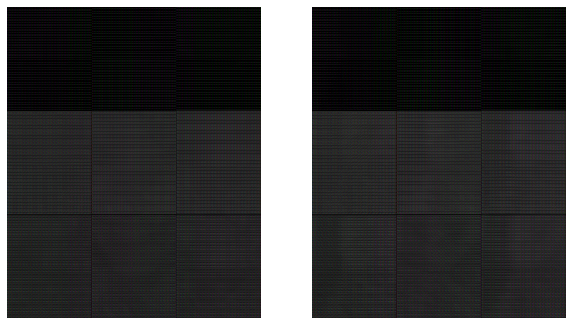

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch ::::  2  d1_loss ::: 0.3446781161427498  d2_loss :::0.6887632051117089
genLoss ::: 9.987723064422607  vggLoss ::: 1.1558669662475587  MeanLoss  ::: 0.12990410447120668


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch ::::  3  d1_loss ::: 0.3326302537325273  d2_loss :::0.3051562851667404
genLoss ::: 15.088699016571045  vggLoss ::: 1.2431126976013183  MeanLoss  ::: 0.1800330647826195


100%|██████████| 25/25 [19:59<00:00, 47.96s/it]


Epoch ::::  4  d1_loss ::: 0.22790008038282394  d2_loss :::0.3450576251745224
genLoss ::: 16.790248298645018  vggLoss ::: 1.4097956943511962  MeanLoss  ::: 0.24608718931674958


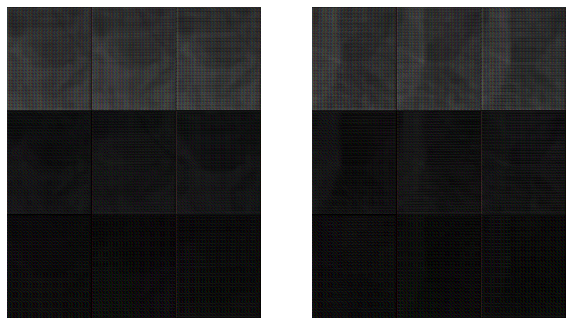

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch ::::  5  d1_loss ::: 1.222974809394218  d2_loss :::0.5097749946375552
genLoss ::: 15.047345037460326  vggLoss ::: 1.1924719762802125  MeanLoss  ::: 0.24669783174991608


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch ::::  6  d1_loss ::: 0.3997072720527649  d2_loss :::0.8315075682755559
genLoss ::: 15.916474151611329  vggLoss ::: 1.212166609764099  MeanLoss  ::: 0.22533595591783523


100%|██████████| 25/25 [19:54<00:00, 47.84s/it]


Epoch ::::  7  d1_loss ::: 0.31497136771678924  d2_loss :::0.5488976874947548
genLoss ::: 13.130979614257813  vggLoss ::: 1.8759463691711427  MeanLoss  ::: 0.4736323034763336


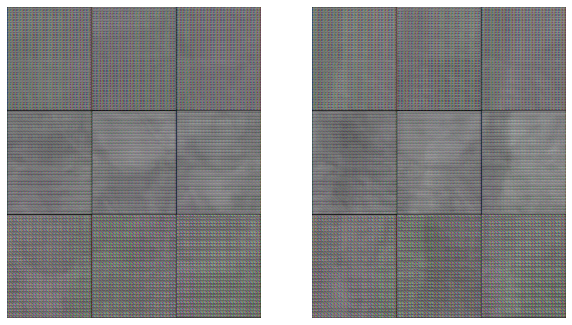

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch ::::  8  d1_loss ::: 0.36580612272024154  d2_loss :::0.584186383188162
genLoss ::: 16.540548334121706  vggLoss ::: 1.5115508508682252  MeanLoss  ::: 0.2616575163602829


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch ::::  9  d1_loss ::: 0.35656482279300705  d2_loss :::0.3169061470031738
genLoss ::: 26.132627034187315  vggLoss ::: 1.4142063093185424  MeanLoss  ::: 0.48742380261421203


100%|██████████| 25/25 [20:37<00:00, 48.78s/it]


Epoch ::::  10  d1_loss ::: 0.22423670345917343  d2_loss :::0.2044784188270569
genLoss ::: 25.995850067138672  vggLoss ::: 1.1103962206840514  MeanLoss  ::: 0.25383718341588973


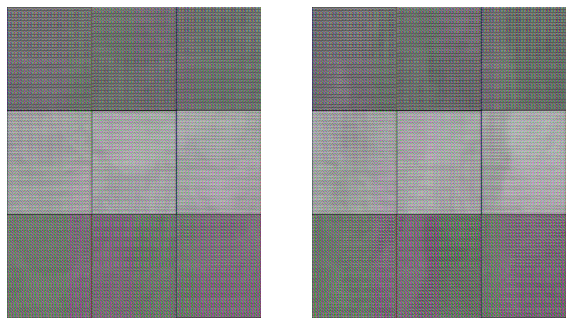

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch ::::  11  d1_loss ::: 1.0708742275834084  d2_loss :::1.4362292963271057
genLoss ::: 21.301639941632747  vggLoss ::: 1.0725041365623473  MeanLoss  ::: 0.17478755563497544


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch ::::  12  d1_loss ::: 1.1087801361083984  d2_loss :::0.8580120006203651
genLoss ::: 13.342158336639404  vggLoss ::: 1.1935970163345337  MeanLoss  ::: 0.34852403283119204


100%|██████████| 25/25 [19:50<00:00, 47.43s/it]


Epoch ::::  13  d1_loss ::: 0.39538012832403635  d2_loss :::0.21554082870483485
genLoss ::: 13.21220500946045  vggLoss ::: 1.2631202220916748  MeanLoss  ::: 0.5014361679553986


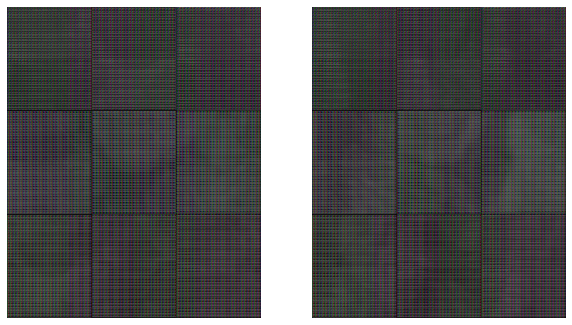

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch ::::  14  d1_loss ::: 0.3747686165571213  d2_loss :::0.4960326972940311
genLoss ::: 7.296145207881928  vggLoss ::: 1.1220302486419678  MeanLoss  ::: 0.1641489112377167


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch ::::  15  d1_loss ::: 0.2777954231807962  d2_loss :::0.26508192691020666
genLoss ::: 8.62418125152588  vggLoss ::: 1.0110167813301087  MeanLoss  ::: 0.15358897924423218


100%|██████████| 25/25 [19:46<00:00, 47.64s/it]


Epoch ::::  16  d1_loss ::: 0.4035178659670055  d2_loss :::0.4436771857738495
genLoss ::: 5.544804275035858  vggLoss ::: 1.0724429535865783  MeanLoss  ::: 0.17533475399017334


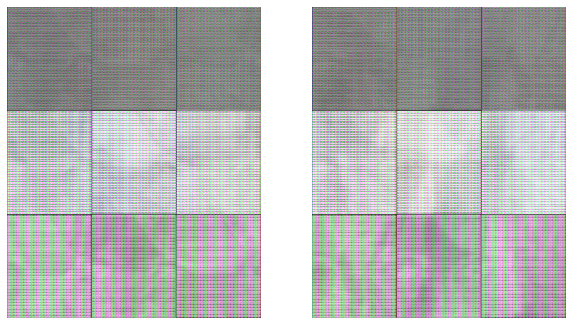

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch ::::  17  d1_loss ::: 0.3090341916682064  d2_loss :::0.3752148246765955
genLoss ::: 8.229425764083862  vggLoss ::: 1.2647298049926758  MeanLoss  ::: 0.29941250205039976


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch ::::  18  d1_loss ::: 0.4108073875315313  d2_loss :::0.3839775674697023
genLoss ::: 6.270144797563553  vggLoss ::: 1.1901975774765015  MeanLoss  ::: 0.20487147688865662


100%|██████████| 25/25 [19:47<00:00, 47.51s/it]


Epoch ::::  19  d1_loss ::: 0.43184017587455403  d2_loss :::0.5456803596019745
genLoss ::: 12.078508815765382  vggLoss ::: 0.99358482837677  MeanLoss  ::: 0.17953262627124786


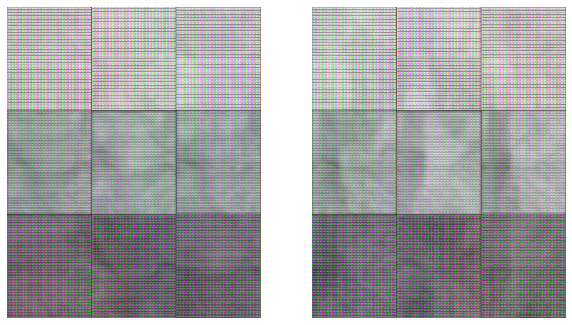

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch ::::  20  d1_loss ::: 0.5797923984192311  d2_loss :::0.4378339797542503
genLoss ::: 7.180039563179016  vggLoss ::: 1.0888057041168213  MeanLoss  ::: 0.1717453995347023


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch ::::  21  d1_loss ::: 0.4096189871430397  d2_loss :::0.35904094398021696
genLoss ::: 7.6941144657135006  vggLoss ::: 1.479594078063965  MeanLoss  ::: 0.24280041694641114


100%|██████████| 25/25 [19:56<00:00, 48.18s/it]


Epoch ::::  22  d1_loss ::: 0.3193005591630936  d2_loss :::0.34053097784519193
genLoss ::: 4.960051209926605  vggLoss ::: 1.053516273498535  MeanLoss  ::: 0.23142174899578094


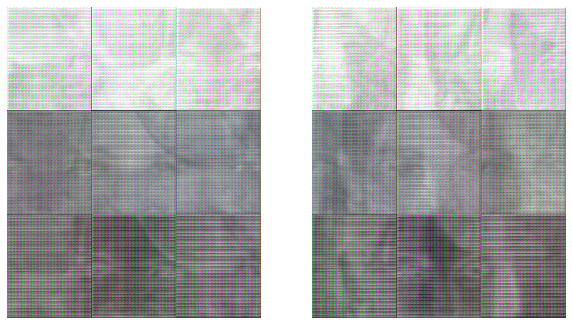

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch ::::  23  d1_loss ::: 0.3572569978942192  d2_loss :::0.34406794111040656
genLoss ::: 6.6037749624252315  vggLoss ::: 1.2097274494171142  MeanLoss  ::: 0.19967953860759735


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch ::::  24  d1_loss ::: 0.4326457030916936  d2_loss :::0.33903593361377715
genLoss ::: 5.732168152332306  vggLoss ::: 1.3524357223510741  MeanLoss  ::: 0.23540763974189757


100%|██████████| 25/25 [19:49<00:00, 47.46s/it]


Epoch ::::  25  d1_loss ::: 0.18550997683560128  d2_loss :::0.3316379812473679
genLoss ::: 9.60731035232544  vggLoss ::: 0.9570918917655945  MeanLoss  ::: 0.3025581192970276


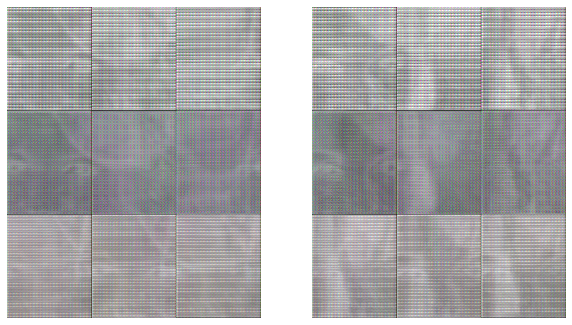

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch ::::  26  d1_loss ::: 0.37048469379313703  d2_loss :::0.33598114865802925
genLoss ::: 8.760132954120635  vggLoss ::: 1.0408407425880433  MeanLoss  ::: 0.2705312043428421


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch ::::  27  d1_loss ::: 0.3036358035355806  d2_loss :::0.3406346684228629
genLoss ::: 5.615230135917663  vggLoss ::: 1.0325157356262207  MeanLoss  ::: 0.15795362174510955


100%|██████████| 25/25 [19:47<00:00, 47.47s/it]


Epoch ::::  28  d1_loss ::: 0.24668875306844712  d2_loss :::0.34406436383724215
genLoss ::: 6.375934162139893  vggLoss ::: 0.9652401256561279  MeanLoss  ::: 0.16385797470808028


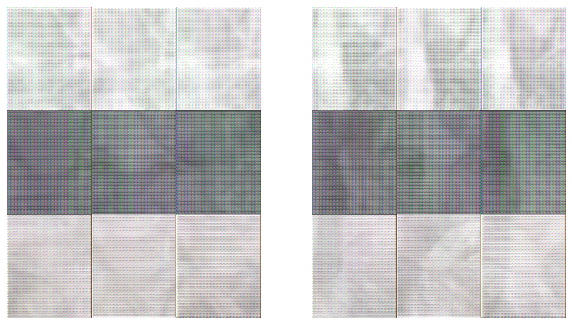

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch ::::  29  d1_loss ::: 0.40198013216257095  d2_loss :::0.453985593020916
genLoss ::: 8.564961624145507  vggLoss ::: 0.9789908266067505  MeanLoss  ::: 0.19643769443035125


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch ::::  30  d1_loss ::: 0.43342684626579286  d2_loss :::0.5497111875796691
genLoss ::: 9.701838603019715  vggLoss ::: 0.8495655369758606  MeanLoss  ::: 0.15341115057468413


100%|██████████| 25/25 [19:43<00:00, 47.24s/it]


Epoch ::::  31  d1_loss ::: 0.35606615803742897  d2_loss :::0.28682061173021794
genLoss ::: 7.775405778884887  vggLoss ::: 0.9456381869316101  MeanLoss  ::: 0.13825058370828627


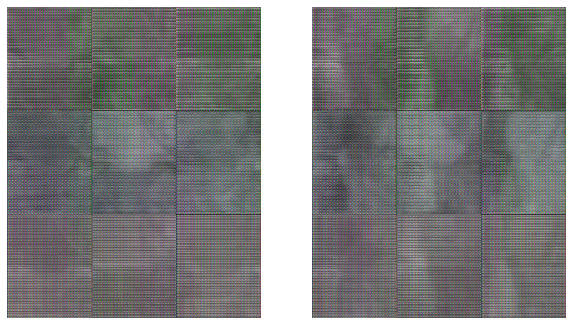

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch ::::  32  d1_loss ::: 0.4305008825659752  d2_loss :::0.34378315433859824
genLoss ::: 6.192287068367005  vggLoss ::: 1.0226844668388366  MeanLoss  ::: 0.13496131360530852


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch ::::  33  d1_loss ::: 0.29198448479175565  d2_loss :::0.2942185506224632
genLoss ::: 5.816859045028687  vggLoss ::: 0.9105283188819885  MeanLoss  ::: 0.13426589131355285


100%|██████████| 25/25 [19:47<00:00, 47.58s/it]


Epoch ::::  34  d1_loss ::: 0.2599067196249962  d2_loss :::0.31748239129781725
genLoss ::: 6.058347864151001  vggLoss ::: 0.8842184019088745  MeanLoss  ::: 0.12045992344617844


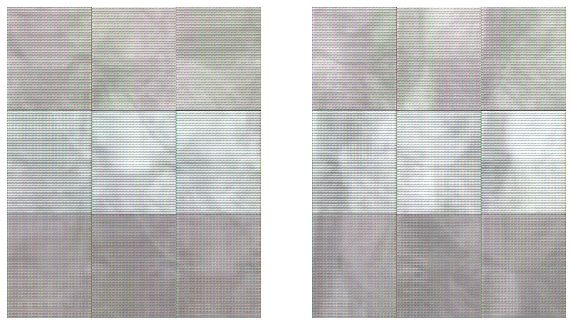

 96%|█████████▌| 24/25 [18:55<00:47, 47.20s/it]

In [0]:
for epoch in range(epochs):
    d1loss_list=[]
    d2loss_list=[]
    gloss_list=[]
    vloss_list=[]
    mloss_list=[]
    
    for batch in tqdm(range(batch_count)):
        hr_imagesList = [img for img in HR_images_list[batch*batch_size:(batch+1)*batch_size]]
        lr_images = loadLRImages(hr_imagesList,hr_path)/255
        hr_images = loadImages(hr_imagesList,hr_path,True)/255
        
        
        disc.zero_grad()
        gen_out = gen(torch.from_numpy(lr_images).to(cuda).float())
        _,f_label = disc(gen_out)
        _,r_label = disc(torch.from_numpy(hr_images).to(cuda).float())
        d1_loss = torch.mean(disc_loss(f_label,torch.zeros_like(f_label,dtype=torch.float)))
        d2_loss = torch.mean(disc_loss(r_label,torch.ones_like(r_label,dtype=torch.float)))
        d_loss = d1_loss+d2_loss
        d2_loss.backward()
        d1_loss.backward(retain_graph=True)
        
#         d_loss.backward(retain_graph=True)
        disc_optimizer.step()
        
        
        gen.zero_grad()
        g_loss = gen_loss(f_label,torch.ones_like(f_label,dtype=torch.float))
        v_loss = vgg_loss(vgg.features[:7](gen_out),vgg.features[:7](torch.from_numpy(hr_images).to(cuda).float()))
        m_loss = mse_loss(gen_out,torch.from_numpy(hr_images).to(cuda).float())
        generator_loss = torch.sum(g_loss+v_loss+m_loss)
        generator_loss.backward()
        gen_optimizer.step()
        
        d1loss_list.append(d1_loss.item())
        d2loss_list.append(d2_loss.item())
        
        gloss_list.append(g_loss.item())
        vloss_list.append(v_loss.item())
        mloss_list.append(m_loss.item())
        
        
        
#         print("d1Loss ::: "+str((d1_loss.item()))+" d2Loss ::: "+str((d2_loss.item())))
#         print("gloss ::: "+str((g_loss.item()))+" vloss ::: "+str((v_loss.item()))+" mloss ::: "+str((m_loss.item())))
    print("Epoch ::::  "+str(epoch+1)+"  d1_loss ::: "+str(np.mean(d1loss_list))+"  d2_loss :::"+str(np.mean(d2loss_list)))
    print("genLoss ::: "+str(np.mean(gloss_list))+"  vggLoss ::: "+str(np.mean(vloss_list))+"  MeanLoss  ::: "+str(np.mean(mloss_list)))
    
    if(epoch%3==0):
        
        checkpoint = {'model': Generator(),
              'input_size': 64,
              'output_size': 256,
              'state_dict': gen.state_dict()}
        torch.save(checkpoint,os.path.join(weight_file,"SR"+str(epoch+1)+".pth"))
        torch.cuda.empty_cache()
        
        out_images = imagePostProcess(images[-2:],os.path.join(weight_file,"SR"+str(epoch+1)+".pth"))
#         print(out_images.shape)
#         test_images = loadLRImages(images[:-3],hr_path)/255
#         test_images = np.reshape(test_images,(test_images[0],test_images.shape[3],test_images.shape[1],test_images.shape[2]))
#         out_images = gen(torch.from_numpy(test_images).to(cuda).float())
#         out_images = np.reshape(out_images,(out_images[0],out_images[2],out_images[3],out_images[1]))
        show_samples(out_images)
#     break